
<font color='blue'> Привет. Извини за долгую проверку. Ниже мои комментарии выделены синим. </font>


<font color='blue'> В начале стоит привести краткое описание целей и задач проекта. </font>

### Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- Лог сервера с данными о посещениях сайта Яндекс.Афиши,
- Выгрузка всех заказов за этот период,
- Статистика рекламных расходов.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
visits.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'uid']
visits

,device,session_end_ts,source_id,session_start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


### Продукт

#### Сколько людей пользуются в день, неделю, месяц?

In [34]:
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'], format="%Y-%m-%d %H:%M:%S")
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'], format="%Y-%m-%d %H:%M:%S")
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_month'] = visits['session_start_ts'].dt.month
visits['session_week']  = visits['session_start_ts'].dt.week
visits['session_date'] = visits['session_start_ts'].dt.date
visits['session_day'] = visits['session_start_ts'].dt.day
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean().astype('int')
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean().astype('int')
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean().astype('int')
print('Показатель DAU:{}'.format(dau_total))
print('Показатель WAU:{}'.format(wau_total))
print('Показатель MAU:{}'.format(mau_total))


Показатель DAU:uid    907
dtype: int64
Показатель WAU:uid    5716
dtype: int64
Показатель MAU:uid    23228
dtype: int64


Достаточно приличное кол-во пользователей


<font color='blue'> Хорошо. </font>

#### Сколько сессий в день?

In [4]:
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users']).round(2)
sessions_per_user['n_sessions_per_day'] = (sessions_per_user['n_sessions'] / 30).round()
sessions_per_user

n_sessions  n_users  sessions_per_user  \
session_year session_month                                           
2017         6                   16505    13259               1.24   
             7                   17828    14183               1.26   
             8                   14355    11631               1.23   
             9                   23907    18975               1.26   
             10                  37903    29692               1.28   
             11                  43969    32797               1.34   
             12                  41983    31557               1.33   
2018         1                   36939    28716               1.29   
             2                   37182    28749               1.29   
             3                   35679    27473               1.30   
             4                   26515    21008               1.26   
             5                   26635    20701               1.29   

                            n_sessions_per_day  
session_year session_month                      
2017         6                           550.0  
             7                           594.0  
             8                           478.0  
             9                           797.0  
             10                         1263.0  
             11                         1466.0  
             12                         1399.0  
2018         1                          1231.0  
             2                          1239.0  
             3                          1189.0  
             4                           884.0  
             5                           888.0

Кол-во сессий в день 3 месяца до нового года и 3 месяца после имеют самые высокие показатели кол-ва сессий в день.
Так же средее кол-во сессий на одного пользователя не превышает 1.34 - это говорит о том, что пользователи заходили для того, чтобы сделать заказ и проверить его. но возвращались редко.

In [5]:
sessions_per_user_1 = visits.groupby(['session_year','session_month','session_day']).agg({'uid':['count', 'nunique']})
sessions_per_user_1.columns = ['count', 'n_sessions_per_day']
sessions_per_user_1.groupby(['session_year', 'session_month']).agg({'n_sessions_per_day':'mean'}).round()

n_sessions_per_day
session_year session_month                    
2017         6                           511.0
             7                           532.0
             8                           433.0
             9                           739.0
             10                         1133.0
             11                         1329.0
             12                         1241.0
2018         1                          1097.0
             2                          1217.0
             3                          1053.0
             4                           846.0
             5                           786.0

In [6]:
session_duration_sec = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds
session_duration_sec.mean() / 60

10.725108143201632

Средняя длительность сессии составляет 10.7 минут

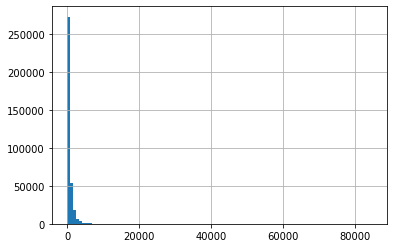

In [7]:
session_duration_sec.hist(bins=100)

Распределение значимо неравномерно. В таком случае расчитаем моду

In [8]:
asl = session_duration_sec.mode()
asl

0    60
dtype: int64


<font color='blue'> Сессии проанализированы хорошо, хотя динамику длины сессии тоже можно посмотреть. </font>

#### Как часто люди возвращаются?

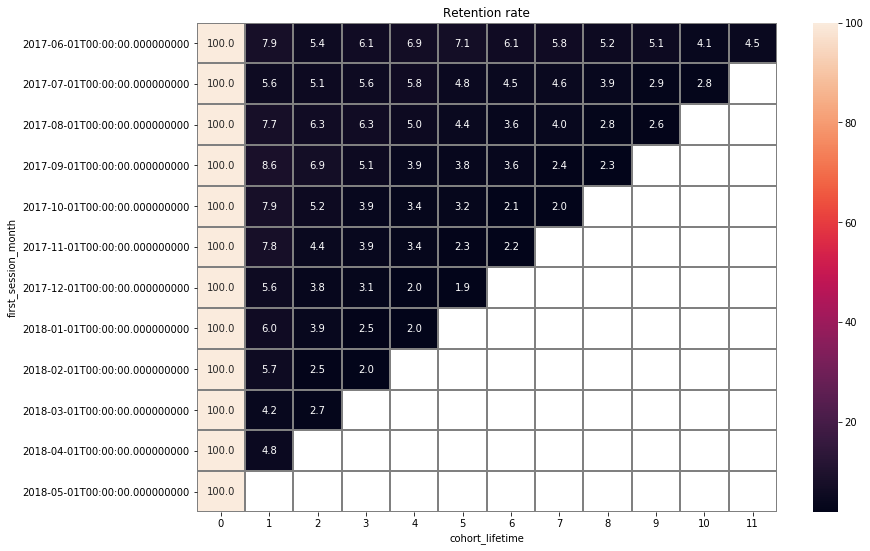

In [9]:
first_session_date = visits.groupby('uid')['session_start_ts'].min()
first_session_date.name = 'first_session_month'
df_ret_prepare = visits.join(first_session_date, on='uid')
df_ret_prepare['first_session_month'] = df_ret_prepare['first_session_month'].astype('datetime64[M]')
df_ret_prepare['session_month'] = df_ret_prepare['session_start_ts'].astype('datetime64[M]')
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['session_month'] - df_ret_prepare['first_session_month']
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['cohort_lifetime'] / np.timedelta64(1,'M')
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['cohort_lifetime'].round().astype('int')

cohorts_ret = (df_ret_prepare
                       .groupby(['first_session_month', 'cohort_lifetime'])
                       .agg({'uid': 'nunique'})
                       .reset_index()
          )

init_users_count = cohorts_ret[cohorts_ret['cohort_lifetime']==0][['first_session_month', 'uid']]
init_users_count = init_users_count.rename(columns={'uid': 'cohort_users'})

cohorts_ret = cohorts_ret.merge(init_users_count, on='first_session_month')
cohorts_ret['retention'] = cohorts_ret['uid']/cohorts_ret['cohort_users']

retention_pivot_rel = cohorts_ret.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')
retention_pivot_rel = (retention_pivot_rel * 100).round(2)
plt.figure(figsize=(13, 9))
plt.title('Retention rate')
sns.heatmap(retention_pivot_rel,  annot=True, fmt='.1f', linewidths=1, linecolor='gray')


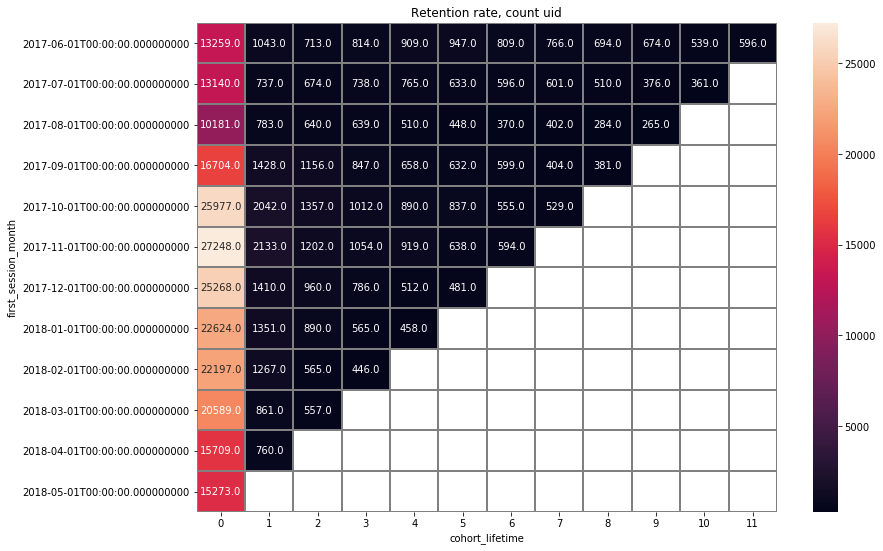

In [10]:
retention_pivot_abs = cohorts_ret.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='uid', aggfunc='sum')
plt.figure(figsize=(13, 9))
plt.title('Retention rate, count uid')
sns.heatmap(retention_pivot_abs,  annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Здесь мы можем отметить, что начиная с октября средняя численность когорты серьезно возросла - с 13000 человек до 20000+ человек. Это вызвано действием 2 факторов:1)именно с октября месяца мы стали значительно вкладываться в рекламу;
2) все вернулись с летних отпусков, поэтому большее количество людей готовы куда-нибудь сходить.
Стоит добавить, что Retention по этим более численным когортам немного ниже, чем у первых трех, тем не менее, по абсолютному показателю мы имеем практически в 2 раза больше пользователей, продолжающих пользоваться нашим ресурсом по сравнению с первыми когортами (кроме первой, которая является аномально активной и "постоянной" на фоне остальных).

<font color='red'> Retention правильно посчитан. </font>


### Продажи

#### Когда люди начинают покупать?

In [11]:
orders.columns=['order_date', 'revenue', 'uid']
costs.columns = ['source_id', 'date', 'costs']
orders['order_date'] = pd.to_datetime(orders['order_date'])
costs['date'] = pd.to_datetime(costs['date']) 

orders['order_month'] = orders['order_date'].astype('datetime64[M]')
costs['month'] = costs['date'].astype('datetime64[M]') 

In [12]:
first_session_date = visits.groupby('uid')['session_start_ts'].min().reset_index()
first_order_date = orders.groupby('uid')['order_date'].min().reset_index()
first_session_and_order_date = first_session_date.merge(first_order_date, on='uid', how='right')
first_session_and_order_date['time_from_session_to_order'] = (first_session_and_order_date['order_date'] - first_session_and_order_date['session_start_ts']).dt.seconds
first_session_and_order_date['time_from_session_to_order'].mean() / 60 / 60

4.152744845713659

По всем когортам среднее время до покупки

In [13]:
first_session_and_order_date['order_month'] = first_session_and_order_date['order_date'].astype('datetime64[M]')
first_session_and_order_date['session_month'] = first_session_and_order_date['session_start_ts'].astype('datetime64[M]')
first_session_and_order_date['age'] = ((first_session_and_order_date['order_month'] - first_session_and_order_date[
                                       'session_month']) / np.timedelta64(1, 'M')).round().astype('int')
first_session_and_order_date_by_cohorts = first_session_and_order_date.pivot_table(index='session_month',
                                                                                   columns='age',
                                                                                  values='time_from_session_to_order',
                                                                                  aggfunc='mean')
first_session_and_order_date_by_cohorts = first_session_and_order_date_by_cohorts / 60 / 60
first_session_and_order_date_by_cohorts.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
session_month,,,,,,,,,,,,
2017-06-01,2.25,11.62,13.03,12.3,12.04,11.57,12.8,10.22,12.94,12.09,11.54,11.34
2017-07-01,2.35,12.28,12.19,12.28,11.93,12.12,11.23,12.16,12.45,12.45,11.14,
2017-08-01,1.99,10.86,10.94,12.79,11.69,9.73,12,13.1,12.87,8.57,,
2017-09-01,2.38,13.63,12.61,10.96,12.91,12.65,13.09,11.39,10.8,,,
2017-10-01,2.36,11.50,11.15,13.43,10.98,11.71,10.56,10.74,,,,
2017-11-01,2.83,12.07,12.54,10.25,11.73,10.76,11.49,,,,,
2017-12-01,2.82,12.29,12.43,11.54,11.92,12.16,,,,,,
2018-01-01,2.74,11.86,11.51,9.21,14.57,,,,,,,
2018-02-01,2.57,12.20,11.18,11.11,,,,,,,,


In [14]:
first_session_and_order_date_by_cohorts_hours = first_session_and_order_date.pivot_table(index='age',
                                                                                         values='time_from_session_to_order',
                                                                                        aggfunc='mean')
first_session_and_order_date_by_cohorts_hours = first_session_and_order_date_by_cohorts_hours / 60 / 60
first_session_and_order_date_by_cohorts_hours.round(2)

,time_from_session_to_order
age,
0,2.49
1,12.05
2,11.90
3,11.69
4,12.10
5,11.69
6,11.96
7,11.41
8,12.30


Логично, что в первый месяц когорта покупает быстрее, чем в последующие месяца, большее среднее время по когортам имеет август, после идет апрель.

От момента первой сессии до момента первой покупки пользователи,в среднем, тратят 4,1 часа.


<font color='blue'> Хорошо. </font>

#### Сколько раз покупают за период?

In [15]:
orders_by_cohorts = orders.groupby('order_month').agg({'uid':'nunique'})
orders_by_cohorts.columns = ['Кол-во покупок в месяц']
orders_by_cohorts

,Кол-во покупок в месяц
order_month,
2017-06-01,2023
2017-07-01,1984
2017-08-01,1472
2017-09-01,2750
2017-10-01,4675
2017-11-01,4547
2017-12-01,4942
2018-01-01,3898
2018-02-01,4258


In [16]:
first_purchase = orders.groupby('uid')['order_date'].min().reset_index()
first_purchase.columns = ['uid', 'first_order']
order_frequency = pd.merge(orders, first_purchase, on='uid')

def time_diff(row):
    date1 = row['order_date']
    date2 = row['first_order']
    return (date1.year - date2.year) * 12 + date1.month - date2.month

order_frequency['time_difference'] = order_frequency.apply(time_diff, axis=1)
order_frequency['first_order'] = order_frequency['first_order'].astype('datetime64[M]')
orders_grouped_by_cohorts = (order_frequency
                                                .groupby(['first_order','time_difference'])
                                                .agg({'order_date': 'count', 'uid': 'nunique'})
                               )

orders_grouped_by_cohorts['order_per_user'] = orders_grouped_by_cohorts['order_date']/orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order', 
                                                          columns='time_difference', 
                                                          values='order_per_user')


In [17]:
orders_per_user = orders_grouped_by_cohorts.groupby('first_order').agg({'order_per_user':'mean'}).round(2)
orders_per_user.columns = ['Среднее кол-во заказов на пользователя в месяц']
orders_per_user

,Среднее кол-во заказов на пользователя в месяц
first_order,
2017-06-01,3.11
2017-07-01,1.63
2017-08-01,1.81
2017-09-01,1.58
2017-10-01,1.44
2017-11-01,1.58
2017-12-01,1.70
2018-01-01,1.64
2018-02-01,1.56


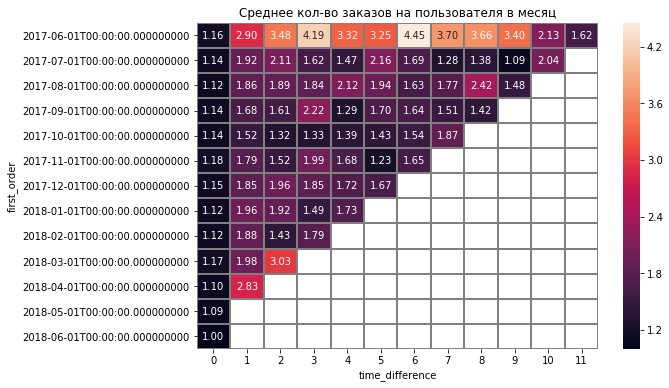

In [18]:
plt.figure(figsize=(9, 6))
plt.title('Среднее кол-во заказов на пользователя в месяц')
sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Выделяется первая когорта по среднему показателю за все периоды и по самому высокому показателю по всем когортам, после идет мартовская когорта за 2018 год и следом апрельяска 2018 года.


<font color='blue'> Здесь надо посчитать среднее количество покупок одного пользователя в месяц. </font>

<font color='red'> Хорошо. </font>


Какой средний чек?

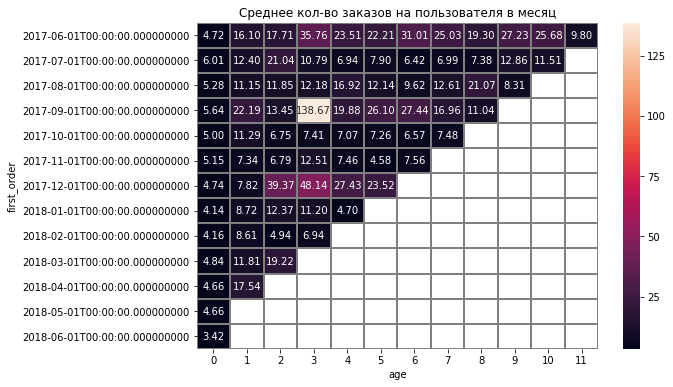

In [20]:
orders_monthly = orders
orders_monthly['order_date'] = orders_monthly['order_date'].astype('datetime64[M]')

first_orders_month = orders_monthly.groupby('uid').agg({'order_date': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_order']

cohort_sizes = first_orders_month.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order', 'n_buyers']

orders_first_orders_month = orders.merge(first_orders_month, on='uid')
cohorts = (orders_first_orders_month
                                    .groupby(['order_date', 'first_order'])
                                    .agg({'revenue': 'sum', 'uid': 'nunique'})
                                    .reset_index()
          )

mean_check = cohorts.merge(cohort_sizes, on='first_order')

time_diff = mean_check['order_date'] - mean_check['first_order']
mean_check['age'] = time_diff / np.timedelta64(1, 'M')
mean_check['age'] = mean_check['age'].round().astype('int')
mean_check['mean_check'] = mean_check['revenue']/mean_check['uid']

mean_check_pivot = mean_check.pivot_table(index='first_order', columns='age', values='mean_check')
plt.figure(figsize=(9, 6))
plt.title('Среднее кол-во заказов на пользователя в месяц')
sns.heatmap(mean_check_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')


Имеются две аномальные когорты на 4-й месяц существования, у них максимальные показатели среднего чека. 
В целом все когорты имеют возрастание среднего чека на 2-й месяц, так же показатели показывают положительный тренд и со временем цифра не опускается ниже начальной.

#### Сколько денег приносят? (LTV)

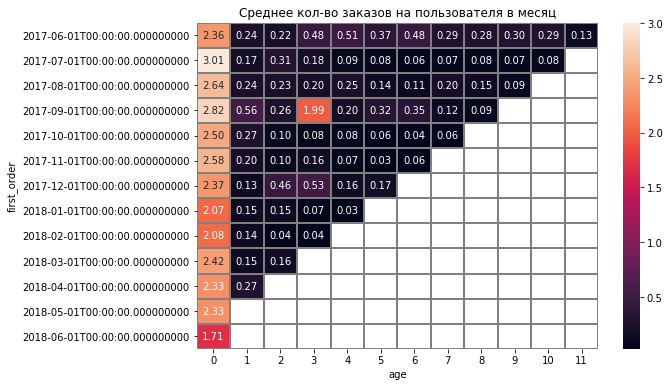

In [21]:
margin_rate = 0.5
LTV = cohorts.merge(cohort_sizes, on='first_order')
LTV['gp'] = LTV['revenue'] * margin_rate
LTV['age'] = (LTV['order_date'] - LTV['first_order']) / np.timedelta64(1, 'M')
LTV['age'] = LTV['age'].round().astype('int')
LTV['ltv'] = LTV['gp'] / LTV['n_buyers']
LTV_pivot = LTV.pivot_table(index="first_order",
                columns="age",
                values="ltv",
                aggfunc='mean')
plt.figure(figsize=(9, 6))
plt.title('Среднее кол-во заказов на пользователя в месяц')
sns.heatmap(LTV_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

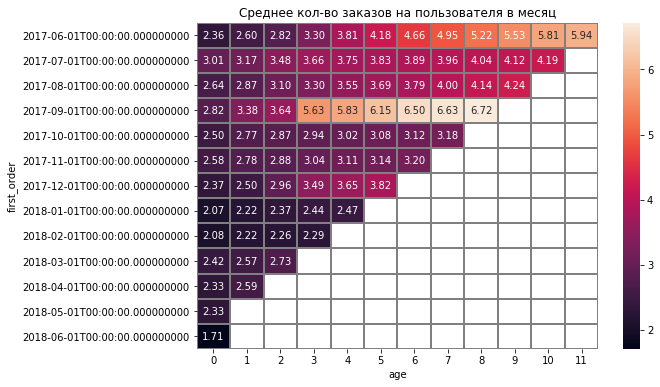

In [22]:
ltv_1 = LTV_pivot.cumsum(axis=1)
plt.figure(figsize=(9, 6))
plt.title('Среднее кол-во заказов на пользователя в месяц')
sns.heatmap(ltv_1, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Для более подробного анализа был выведен как "точечный" LTV (значение LTV в каждый отдельный месяц - 1 график), так и накопительный (2 график). Можно заметить, что первые когорты (2017 года) были более "качественные", чем последующие - их накопительный LTV заметно выше, чем по остальным когортам.


Также можно отметить, что 1ая когорта была самая стабильная - практически в каждом месяце она показывала лучший результат по LTV среди всех когорт. Вызвано это тем, что именно эта когорта показывает лучший показатель Retention - как относительный, так и абсолютный.
По 4-й когорте (сентябрьской) необходимо исследовать 3-й месяц её жизни - там у нас аномальный всплеск месячного значения LTV практически до 2 т.р.


<font color='blue'> Для ltv нужно считать аккумулированное значение. Т.е. для 3 месяца ltv, то сколько пользователь потратил в 0+1+2+3 месяцы. </font>


<font color='blue'> Нет ответа на вопрос: Как часто люди возвращаются?. </font>

<font color='blue'> Для ответа на  этот вопрос надо посчитать количество визитов по кагортам, а потом в цикле посчитать retention. </font>

    retention = pd.DataFrame()
    for col in cohorts.columns:
        retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
    retention.columns = cohorts.columns
    
<font color='red'> Ок, все верно. Хотя здесь тоже маржинальность надо брать 1. </font>

### Маркетинг

#### Сколько денег потратили? Всего / на каждый источник / по времени

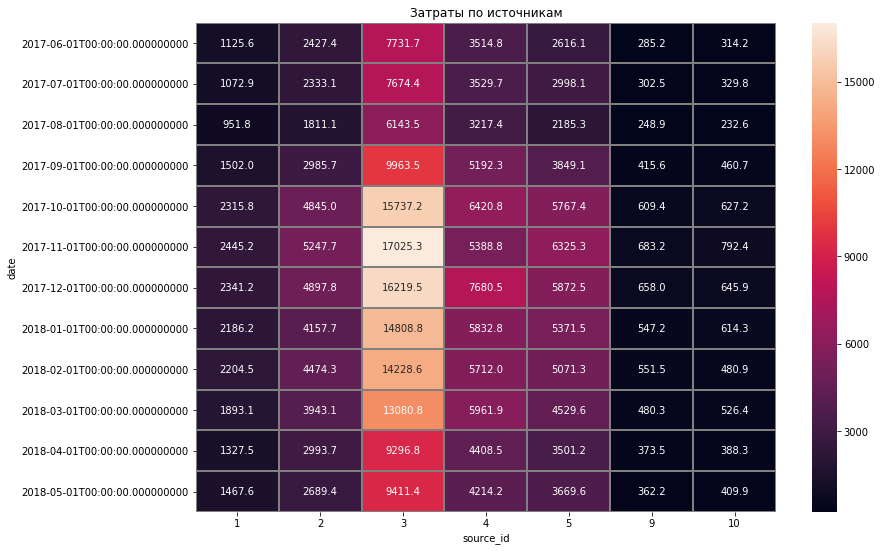

In [23]:
costs_by_source = (costs
                              .groupby(['source_id', 'date'])['costs']
                              .sum()
                              .reset_index()
                             )
costs_by_source['date'] = costs_by_source['date'].astype('datetime64[M]')
costs_by_source = costs_by_source.groupby(['source_id', 'date'])['costs'].sum().reset_index()
costs_by_source_pivot = costs_by_source.pivot_table(index='date', columns='source_id', values='costs', aggfunc='sum')
plt.figure(figsize=(13, 9))
plt.title('Затраты по источникам')
sns.heatmap(costs_by_source_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')


In [24]:
costs_by_source.pivot_table(index='source_id', values='costs', aggfunc='sum')

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Как вы видим самый затратный источник 3-й, после идут 4-й, 5-й, 2-й.


<font color='blue'> здесь надо разделить затраты по источникам и построить график. </font>

<font color='red'> Хорошо. </font>


### Не разобрался как можно построить график по этим данным, приведи пример, пожалуйста

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [25]:
visits_sorted = visits.sort_values(by='session_start_ts')

costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})
first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})

rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})

rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source.columns = ['costs', 'revenue', 'uid', 'users']
rev_uid_costs_per_source['cac'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['users']
rev_uid_costs_per_source['cac'] = rev_uid_costs_per_source['cac'].round(2)
rev_uid_costs_per_source['cac'].sort_values(ascending=False).to_frame()

,cac
source_id,
3,13.49
2,12.21
5,7.47
1,7.19
4,5.93
9,5.07
10,4.38
7,0.00
6,NaN



<font color='blue'> Почему для каждого источника сас получился одинаковым? Это не удивило? Конечно, это не верно. Здесь не надо делать кагортного анализа, надо корректнго посчитать итоговый сас для каждого источника. </font>

<font color='red'> Теперь все верно. </font>


#### На сколько окупились расходы? (ROI)

In [26]:
margin_rate = 0.5
rev_uid_costs_per_source['gp'] = rev_uid_costs_per_source['revenue'] * margin_rate
rev_uid_costs_per_source['ltv'] = rev_uid_costs_per_source['gp'] / rev_uid_costs_per_source['users']
rev_uid_costs_per_source['roi'] = rev_uid_costs_per_source['ltv'] / rev_uid_costs_per_source['cac']
df = rev_uid_costs_per_source.reset_index()
roi_by_source = df.pivot_table(index='source_id', values=['roi', 'ltv', 'cac', 'costs', 'gp', 'users'])
roi_by_source.round(2)

,cac,costs,gp,ltv,roi,users
source_id,,,,,,
1,7.19,20833.27,15545.27,5.36,0.75,2899.0
2,12.21,42806.04,23461.81,6.69,0.55,3506.0
3,13.49,141321.63,27255.62,2.60,0.19,10473.0
4,5.93,61073.60,28348.42,2.75,0.46,10296.0
5,7.47,51757.10,26312.01,3.80,0.51,6931.0
6,NaN,0.00,0.00,NaN,NaN,0.0
7,0.00,0.00,0.61,0.61,inf,1.0
9,5.07,5517.49,2879.70,2.65,0.52,1088.0
10,4.38,5822.49,2225.16,1.67,0.38,1329.0


In [27]:
margin_rate = 1
rev_uid_costs_per_source['gp'] = rev_uid_costs_per_source['revenue'] * margin_rate
rev_uid_costs_per_source['ltv'] = rev_uid_costs_per_source['gp'] / rev_uid_costs_per_source['users']
rev_uid_costs_per_source['roi'] = rev_uid_costs_per_source['ltv'] / rev_uid_costs_per_source['cac']
df = rev_uid_costs_per_source.reset_index()
roi_by_source_1 = df.pivot_table(index='source_id', values=['roi', 'ltv', 'cac', 'costs', 'gp', 'users'])
roi_by_source_1.round(2)

,cac,costs,gp,ltv,roi,users
source_id,,,,,,
1,7.19,20833.27,31090.55,10.72,1.49,2899.0
2,12.21,42806.04,46923.61,13.38,1.10,3506.0
3,13.49,141321.63,54511.24,5.20,0.39,10473.0
4,5.93,61073.60,56696.83,5.51,0.93,10296.0
5,7.47,51757.10,52624.02,7.59,1.02,6931.0
6,NaN,0.00,0.00,NaN,NaN,0.0
7,0.00,0.00,1.22,1.22,inf,1.0
9,5.07,5517.49,5759.40,5.29,1.04,1088.0
10,4.38,5822.49,4450.33,3.35,0.76,1329.0


<font color='red'> Вот отлично. Это то, что нужно. </font>


In [28]:
costs_copy = costs.copy()
costs_copy['date'] = costs_copy['date'].values.astype('datetime64[M]') 
costs_grouped = costs_copy.groupby('date').agg({'costs': 'sum'})
orders_grouped = orders_monthly.groupby('order_date').agg({'revenue': 'sum'})
data = {'summary': [round(orders_grouped.sum().values[0], 2),round(costs_grouped.sum().values[0], 2)]}
rev_costs = pd.DataFrame(data=data, index=['revenue', 'costs'])
rev_costs

,summary
revenue,252057.20
costs,329131.62


При маржинальности 50% ни один из источников не окупается, при маржинальности в 100 процентов, окупаются 1-й, 2-й, 9-й, 5-й источники. Компания работает в убыток, по предоставленным данным, затраты превышают прибыль на 30%.

In [29]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
visits_by_device

,uid
device,
desktop,262567
touch,96833


73 процента посещений совершаются с ПК и, соотвественно, 27 процентов с телефона.

#### Общим выводом будет то, что нужно сконцетрироваться на 1-ом источнике, он имеет большую окупаемость, так же нужно обратить внимание на 2-й и 5-й каналы, они имеют хороший потенциал. Исходя из анализа LTV, CAC, ROMI самая прибыльная аудитория у 2-го ситочника, самый дорогой канал рекламы - 3-й, самый большой канал по аудитории и с наименьшими затратами на привлечения 4-й канал.

<font color='red'> В целом проект очень хорошо доработан. Молодец, с проектом справился.</font>